In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import datetime

from glob import glob
from natsort import natsorted
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm.auto import tqdm
from unet import *

torch.backends.cudnn.benchmark = True

/home/bnorthan/mambaforge/envs/easy_augment_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
npz_dir = '/home/bnorthan/images/deep-learning/tissuenet_v1.1/'
test_dict = np.load(os.path.join(npz_dir, 'tissuenet_v1.1_test.npz'))

In [3]:
test_X, test_y = test_dict['X'], test_dict['y']

In [4]:
test_X.shape, test_y.shape

((1324, 256, 256, 2), (1324, 256, 256, 2))

In [5]:
# utility function to view labels as rgb lut with matplotlib
# eg plt.imshow(create_lut(labels))

def create_lut(labels):

    max_label = np.max(labels)

    lut = np.random.randint(
            low=0,
            high=255,
            size=(int(max_label + 1), 3),
            dtype=np.uint8)

    lut = np.append(
            lut,
            np.zeros(
                (int(max_label + 1), 1),
                dtype=np.uint8) + 255,
            axis=1)

    lut[0] = 0
    colored_labels = lut[labels]

    return colored_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..9968.0].


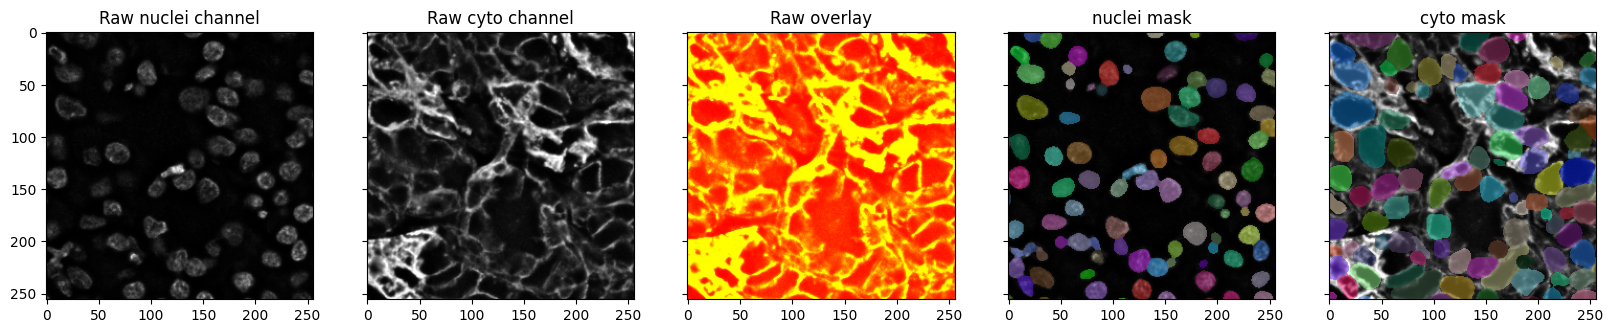

In [6]:
# convenience functions for viewing labels as rgb, and reading files into numpy arrays
from skimage import color
from skimage.io import imread

# select a random cytoplasm mask file
#cyto_file = random.choice(train_cyto)

n=900
# use skimage.io.imread to read our data into numpy arrays
cyto = test_y[n][:,:,0]#imread(cyto_file)
nuclei = test_y[n][:,:,1]#imread(cyto_file.replace('cyto', 'nuclei'))
raw = test_X[n]#imread(cyto_file.replace('_cyto_masks', ''))

#our raw data shape is (c, h, w) and there are only two channels.
#to visualize as an rgb image we need to add another dummy dimension and then transpose so that it is (h,w,3)
#raw = np.vstack((raw, np.zeros_like(raw)[:1]))
#raw = raw.transpose(1,2,0)
raw = np.concatenate((raw, np.zeros_like(raw)[:,:,:1]), axis=-1)
# visualize the data - execute this cell a few times to see different examples.
# you can also change train_cyto to test_cyto above to see some test data. it is pretty similar 
fig, axes = plt.subplots(1,5,figsize=(20, 10),sharex=True,sharey=True,squeeze=False)

axes[0][0].imshow(raw[:,:,0], cmap='gray')
axes[0][0].title.set_text('Raw nuclei channel')

axes[0][1].imshow(raw[:,:,1], cmap='gray')
axes[0][1].title.set_text('Raw cyto channel')

axes[0][2].imshow(raw)
axes[0][2].title.set_text('Raw overlay')

axes[0][3].imshow(raw[:,:,0], cmap='gray')
axes[0][3].imshow(create_lut(nuclei), alpha=0.5)
axes[0][3].title.set_text('nuclei mask')

axes[0][4].imshow(raw[:,:,1], cmap='gray')
axes[0][4].imshow(create_lut(cyto), alpha=0.5)
axes[0][4].title.set_text('cyto mask')

In [7]:
import napari
viewer = napari.Viewer()

viewer.add_image(raw[:,:,0], name='nuclei', colormap='gray')
viewer.add_image(raw[:,:,1], name='cyto', colormap='gray')
viewer.add_labels(nuclei, name='nuclei mask')
viewer.add_labels(cyto, name='cyto mask')

<Labels layer 'cyto mask' at 0x7fc790bbf530>

In [8]:
test_X.shape, test_y.shape

((1324, 256, 256, 2), (1324, 256, 256, 2))

In [9]:
import albumentations as A

class TissueNetDataset(Dataset):
    def __init__(self,
                 X,
                 y,
                 split='train',
                 crop_size=64,
                 prediction_type='two_class'
                ):
        self.X  = X
        self.y = y
        self.split = split
        self.crop_size = crop_size   
        self.prediction_type = prediction_type
        # use the root dir, split and mask logic to point to the correct files
        #self.mask_files = ... # load mask files into sorted list
        #self.raw_files = ... # load raw files into sorted list
                
    def __len__(self):
        return self.X.shape[0]
    
    def augment_data(self, raw, mask):
        
        transform = A.Compose([
              A.RandomCrop(width=self.crop_size, height=self.crop_size),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5)
            ])

        transformed = transform(image=raw, mask=mask)

        raw, mask = transformed['image'], transformed['mask']
       
        return raw, mask
    
    def create_target(self, mask, prediction_type):
        
        mask, border = erode(
                    mask,
                    iterations=1,
                    border_value=1)
        
        if self.prediction_type == 'two_class':
            mask = (mask != 0)

        elif self.prediction_type == 'three_class':
            labels_two_class = (mask != 0)
            border[border!=0] = 2
            
            mask = labels_two_class + border

        elif self.prediction_type == 'sdt':
            mask = compute_sdt(mask)

        elif self.prediction_type == 'affs':
            mask = compute_affinities(mask, nhood=[[0,1],[1,0]])

        else:
            raise Exception('Choose from one of the following prediction types: two_class, three_class, sdt, affs')
        
        return mask.astype(np.float32)

        
    def __getitem__(self, idx):
        
        raw = self.X[idx,:, :, 0] # load raw to numpy array
        mask = self.y[idx, :, :, 1] # load mask to numpy array
        
        # if training, run augmentations
        if self.split == 'train':
            raw, mask = self.augment_data(raw, mask)
        
        #fg = erode(
        #            mask,
        #            iterations=1,
        #            border_value=1)
        mask = self.create_target(mask, self.prediction_type)
        
        #mask = (fg != 0).astype(np.float32)

        # add channel dim for network
        raw = np.expand_dims(raw, axis=0)
        raw = raw.astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        return raw, mask

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.24 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [10]:
train_dataset = TissueNetDataset(test_X[:100], test_y[:100], crop_size=64)

In [11]:
# convenience functions to create our three extra representations (three class, sdt, affs)
# run this cell to initialize these functions for our dataset
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import binary_erosion

# utility function to compute a three class representation
def erode(labels, iterations, border_value):

    # copy labels to memory, create border array
    labels = np.copy(labels)
    border = np.array(labels)

    # create zeros array for foreground
    foreground = np.zeros_like(labels, dtype=bool)

    # loop through unique labels
    for label in np.unique(labels):

        # skip background
        if label == 0:
            continue

        # mask to label
        label_mask = labels == label

        # erode labels
        eroded_mask = binary_erosion(
                label_mask,
                iterations=iterations,
                border_value=border_value)

        # get foreground
        foreground = np.logical_or(eroded_mask, foreground)

    # and background...
    background = np.logical_not(foreground)

    # set eroded pixels to zero
    labels[background] = 0

    # get eroded pixels
    border = labels - border

    return labels, border



# utility function to compute a signed distance transform
def compute_sdt(labels, constant=0.5, scale=5):

    inner = distance_transform_edt(binary_erosion(labels))
    outer = distance_transform_edt(np.logical_not(labels))

    distance = (inner - outer) + constant

    distance = np.tanh(distance / scale)

    return distance


# utility function to compute edge affinities
def compute_affinities(seg, nhood):

    nhood = np.array(nhood)

    shape = seg.shape
    nEdge = nhood.shape[0]
    dims = nhood.shape[1]
    aff = np.zeros((nEdge,) + shape, dtype=np.int32)

    for e in range(nEdge):
        aff[e, \
          max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
          max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1])] = \
                      (seg[max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                          max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1])] == \
                        seg[max(0,nhood[e,0]):min(shape[0],shape[0]+nhood[e,0]), \
                          max(0,nhood[e,1]):min(shape[1],shape[1]+nhood[e,1])] ) \
                      * ( seg[max(0,-nhood[e,0]):min(shape[0],shape[0]-nhood[e,0]), \
                          max(0,-nhood[e,1]):min(shape[1],shape[1]-nhood[e,1])] > 0 ) \
                      * ( seg[max(0,nhood[e,0]):min(shape[0],shape[0]+nhood[e,0]), \
                          max(0,nhood[e,1]):min(shape[1],shape[1]+nhood[e,1])] > 0 )
                          

    return aff


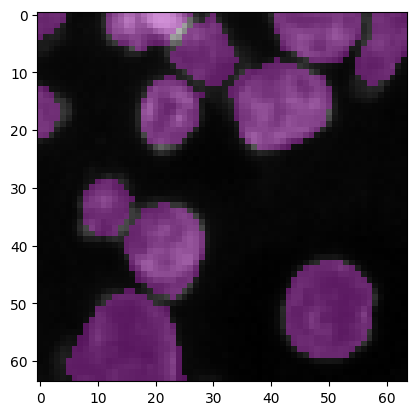

In [12]:
# visualize random batch

raw, mask = train_dataset[random.randrange(len(train_dataset))]
    
plt.imshow(np.squeeze(raw), cmap='gray')
plt.imshow(create_lut(np.squeeze(mask).astype('uint16')), alpha=0.5)

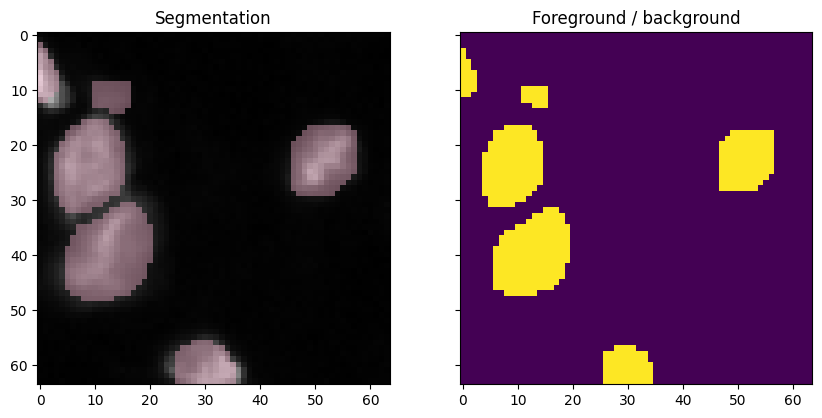

In [13]:
# visualize the representation (repeatedly run cell)

raw, mask = train_dataset[random.randrange(len(train_dataset))]

labels, _ = erode(
    mask,
    iterations=1,
    border_value=1)

labels_two_class = (labels != 0).astype(np.float32)

fig, axes = plt.subplots(1,2,figsize=(10, 10),sharex=True,sharey=True,squeeze=False)

axes[0][0].imshow(np.squeeze(raw), cmap='gray')
axes[0][0].title.set_text('Raw')

axes[0][0].imshow(create_lut(np.squeeze(mask).astype('uint16')), alpha=0.5)
axes[0][0].title.set_text('Segmentation')

axes[0][1].imshow(np.squeeze(labels_two_class))
axes[0][1].title.set_text('Foreground / background')

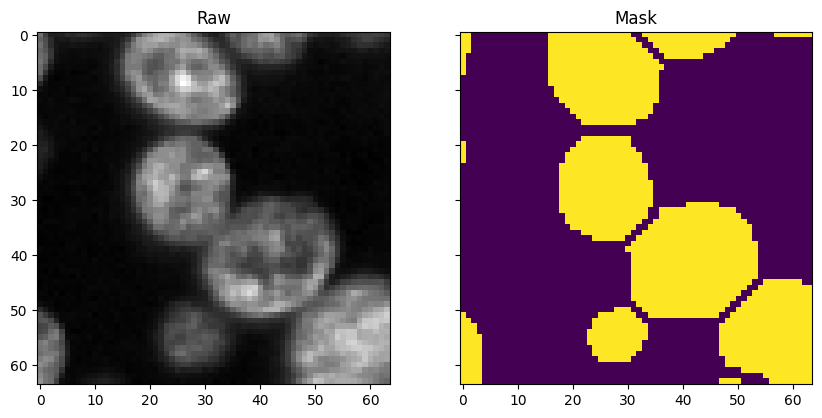

In [14]:
# run cell repeatedly to see different crops

raw, mask = train_dataset[random.randrange(len(train_dataset))]

fig, axes = plt.subplots(1,2,figsize=(10, 10),sharex=True,sharey=True,squeeze=False)

axes[0][0].imshow(np.squeeze(raw), cmap='gray')
axes[0][0].title.set_text('Raw')

axes[0][1].imshow(np.squeeze(mask))
axes[0][1].title.set_text('Mask')

In [15]:
train_dataset = TissueNetDataset(test_X[:100], test_y[:100], crop_size=64)
test_dataset = TissueNetDataset(test_X[100:200], test_y[100:200], crop_size=64)
val_dataset = TissueNetDataset(test_X[200:300], test_y[200:300], crop_size=64)

Field of view at depth 1:   5 (color: yellow)
Field of view at depth 2:  18 (color: red)
Field of view at depth 3:  44 (color: green)


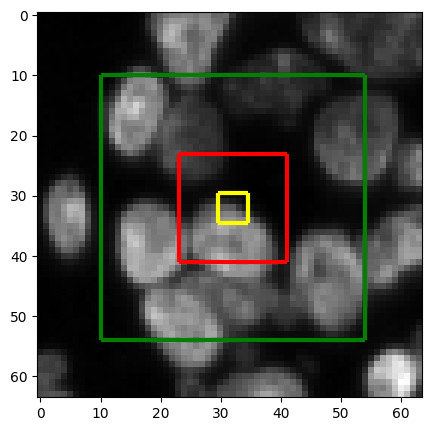

In [16]:
raw, mask = train_dataset[random.randrange(len(train_dataset))]

net_t = raw
fovs = []
d_factors = [[2,2],[2,2]]

net = UNet(in_channels=1,
           num_fmaps=6,
           fmap_inc_factors=2,
           downsample_factors=d_factors,
           padding='same'
          )

for level in range(len(d_factors)+1):
    fov_tmp, _ = net.rec_fov(level , (1, 1), 1)
    fovs.append(fov_tmp[0])

fig=plt.figure(figsize=(5, 5))
colors = ["yellow", "red", "green"]

plt.imshow(np.squeeze(raw), cmap='gray')

for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = raw.shape[1]/2 - fov_t/2
    xmax = raw.shape[1]/2 + fov_t/2
    ymin = raw.shape[1]/2 - fov_t/2
    ymax = raw.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()

In [17]:
#### Solution ####

out_channels = 1
activation = torch.nn.Sigmoid()
loss_fn = torch.nn.BCELoss()
dtype = torch.FloatTensor

torch.manual_seed(42)

d_factors = [[2,2],[2,2]]
in_channels=1
num_fmaps=32
fmap_inc_factors=2
padding='same'
final_kernel_size=1

unet = UNet(
        in_channels=in_channels,
        num_fmaps=num_fmaps,
        fmap_inc_factors=fmap_inc_factors,
        downsample_factors=d_factors,
        padding=padding)

final_conv = torch.nn.Conv2d(
    in_channels=num_fmaps,
    out_channels=out_channels,
    kernel_size=final_kernel_size)

net = torch.nn.Sequential(unet, final_conv)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)

summary(net, (in_channels, 384, 384))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 384, 384]             320
              ReLU-2         [-1, 32, 384, 384]               0
       BatchNorm2d-3         [-1, 32, 384, 384]              64
            Conv2d-4         [-1, 32, 384, 384]           9,248
              ReLU-5         [-1, 32, 384, 384]               0
       BatchNorm2d-6         [-1, 32, 384, 384]              64
          ConvPass-7         [-1, 32, 384, 384]               0
         MaxPool2d-8         [-1, 32, 192, 192]               0
        Downsample-9         [-1, 32, 192, 192]               0
           Conv2d-10         [-1, 64, 192, 192]          18,496
             ReLU-11         [-1, 64, 192, 192]               0
      BatchNorm2d-12         [-1, 64, 192, 192]             128
           Conv2d-13         [-1, 64, 192, 192]          36,928
             ReLU-14         [-1, 64, 1

In [18]:
def model_step(model, loss_fn, optimizer, feature, label, activation, prediction_type=None, train_step=True):
    
    # zero gradients if training
    if train_step:
        optimizer.zero_grad()
    
    # forward
    logits = model(feature)
    
    if prediction_type == "three_class":
        label=torch.squeeze(label,1)
        
    # final activation
    predicted = activation(logits)

    # pass through loss
    loss_value = loss_fn(input=predicted, target=label)
    
    # backward if training mode
    if train_step:
        loss_value.backward()
        optimizer.step()

    outputs = {
        'pred': predicted,
        'logits': logits,
    }
    
    return loss_value, outputs

In [19]:
def train(train_loader, val_loader, net, loss_fn, activation, optimizer, dtype, prediction_type=None):

    # set train flags, initialize step
    net.train() 
    loss_fn.train()
    step = 0

    with tqdm(total=training_steps) as pbar:
        while step < training_steps:
            # reset data loader to get random augmentations
            np.random.seed()
            tmp_loader = iter(train_loader)
            for feature, label in tmp_loader:
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                loss_value, pred = model_step(net, loss_fn, optimizer, feature, label, activation, prediction_type)
                writer.add_scalar('loss',loss_value.cpu().detach().numpy(),step)
                step += 1
                pbar.update(1)
                if step % 100 == 0:
                    net.eval()
                    tmp_val_loader = iter(val_loader)
                    acc_loss = []
                    for feature, label in tmp_val_loader:                    
                        label = label.type(dtype)
                        label = label.to(device)
                        feature = feature.to(device)
                        loss_value, _ = model_step(net, loss_fn, optimizer, feature, label, activation, prediction_type, train_step=False)
                        acc_loss.append(loss_value.cpu().detach().numpy())
                    writer.add_scalar('val_loss',np.mean(acc_loss),step)
                    net.train()

                    print(np.mean(acc_loss))

In [20]:
#### Solution ####

train_batch_size = 4
test_batch_size = 1

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

training_steps = 1000

# create a logdir for each run and a corresponding summary writer
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

# make sure net and loss are cast to our device (should be gpu, can check by printing device)
net = net.to(device)
loss_fn = loss_fn.to(device)

# set optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# run training loop
train(train_loader, val_loader, net, loss_fn, activation, optimizer, dtype)

 12%|█▎        | 125/1000 [00:01<00:08, 102.88it/s]

0.5113034


 23%|██▎       | 231/1000 [00:02<00:06, 122.16it/s]

0.55903643


 32%|███▏      | 320/1000 [00:02<00:05, 124.23it/s]

0.6805432


 42%|████▏     | 421/1000 [00:03<00:05, 114.95it/s]

0.6405564


 52%|█████▎    | 525/1000 [00:04<00:04, 104.43it/s]

0.6326244


 63%|██████▎   | 628/1000 [00:05<00:03, 108.25it/s]

0.51747257


 72%|███████▏  | 717/1000 [00:06<00:02, 104.12it/s]

0.8011624


 81%|████████▏ | 814/1000 [00:07<00:02, 90.88it/s] 

0.56583464


 92%|█████████▏| 924/1000 [00:07<00:00, 115.08it/s]

0.5793699


100%|██████████| 1000/1000 [00:08<00:00, 115.56it/s]

0.57025754


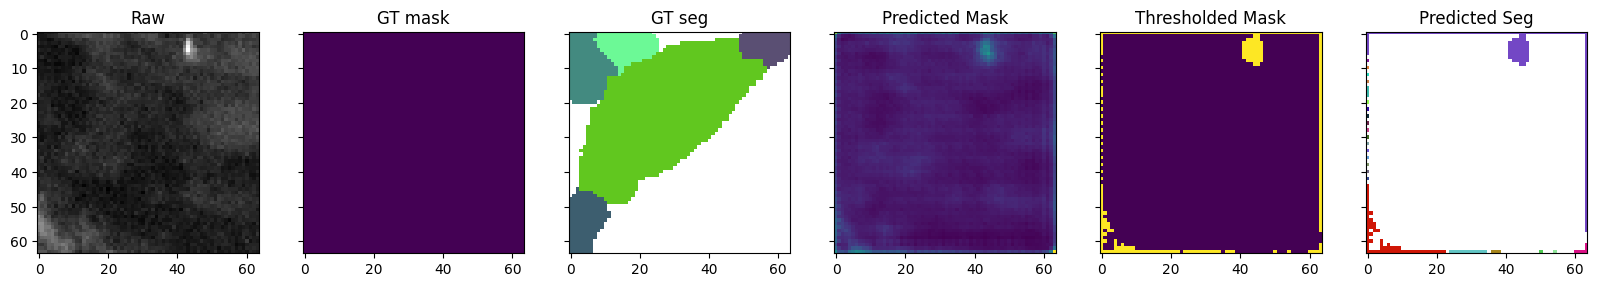

In [21]:
# convenience functions to threshold mask and relabel connected components as unique objects
from skimage.filters import threshold_otsu
from skimage.measure import label as relabel_cc

# make sure net is in eval mode so we don't backprop
net.eval()

for idx, (image, mask) in enumerate(test_loader):
    
    # move image to device
    image = image.to(device)
    
    # pass image through network
    logits = net(image)
    
    # pass logits through activation
    pred = activation(logits)
        
    # get our tensors to numpy arrays so we can post-process / visualize
    image = image.cpu()
    mask = mask.cpu().numpy()
    
    # we need to detach our predicted tensor
    pred = pred.cpu().detach().numpy()

    # we also need to remove the batch/channel dimensions from the arrays for visualizing
    # (b,c,h,w) -> (h, w)
    image = np.squeeze(np.squeeze(image))
    mask = np.squeeze(np.squeeze(mask))
    pred = np.squeeze(np.squeeze(pred))
                
    # get threshold value (How does the segmentation change if we change to 0.1 / 0.8?)
    thresh = threshold_otsu(pred)
    
    # fg = prediction greater than / equal to threshold
    boundary_mask = pred >= thresh
    
    # relabel all boundary_mask connected pixels as unique objects
    labeled = relabel_cc(boundary_mask)
    
    # get the corresponding gt labels to visualize
    gt_labels = test_loader.dataset.y[idx,:,:,0] #imread(test_loader.dataset.mask_files[idx])
    
    fig, axes = plt.subplots(1,6,figsize=(20, 20),sharex=True,sharey=True,squeeze=False)
        
    axes[0][0].imshow(image, cmap='gray')
    axes[0][0].title.set_text('Raw')

    axes[0][1].imshow(mask)
    axes[0][1].title.set_text('GT mask')
    
    axes[0][2].imshow(create_lut(gt_labels))
    axes[0][2].title.set_text('GT seg')
    
    axes[0][3].imshow(pred)
    axes[0][3].title.set_text('Predicted Mask')
    
    axes[0][4].imshow(boundary_mask)
    axes[0][4].title.set_text('Thresholded Mask')

    axes[0][5].imshow(create_lut(labeled))
    axes[0][5].title.set_text('Predicted Seg')

    break

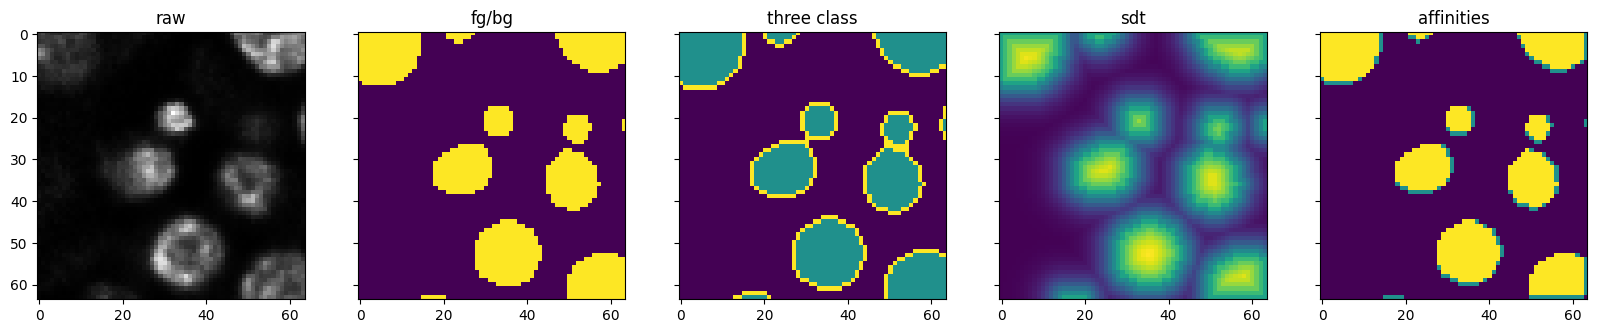

In [22]:
# compute each representation and visualize

#file = random.choice(train_nuclei)

#full_mask_nuclei = imread(file)
#full_raw_nuclei = imread(file.replace('_nuclei_masks', ''))[0]


# select a random cytoplasm mask file
#cyto_file = random.choice(train_cyto)

n=900
# use skimage.io.imread to read our data into numpy arrays
full_mask_nuclei = test_y[n][:,:,1]#imread(cyto_file)
full_raw_nuclei = test_X[n][:,:,0]#imread(cyto_file.replace('_cyto_masks', ''))

transform = A.Compose([
              A.RandomCrop(width=64, height=64),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5)
            ])

transformed = transform(image=full_raw_nuclei, mask=full_mask_nuclei)
          
aug_raw, aug_mask = transformed['image'], transformed['mask']
    
labels, border = erode(
    aug_mask,
    iterations=1,
    border_value=1)

labels_two_class = (labels != 0)
border[border!=0] = 2

labels_three_class = (labels_two_class + border)
sdt = compute_sdt(labels)
affs = compute_affinities(labels, nhood=[[0,1],[1,0]])

fig, axes = plt.subplots(1,5,figsize=(20, 10),sharex=True,sharey=True,squeeze=False)

for idx, (ds_name, data) in enumerate([
    ('raw', aug_raw),
    ('fg/bg', labels_two_class),
    ('three class', labels_three_class),
    ('sdt', sdt),
    ('affinities', affs[0] + affs[1])]
):

    cmap = 'gray' if ds_name == 'raw' else 'viridis'

    axes[0][idx].imshow(data.astype(np.float32), cmap=cmap)
    axes[0][idx].title.set_text(ds_name)

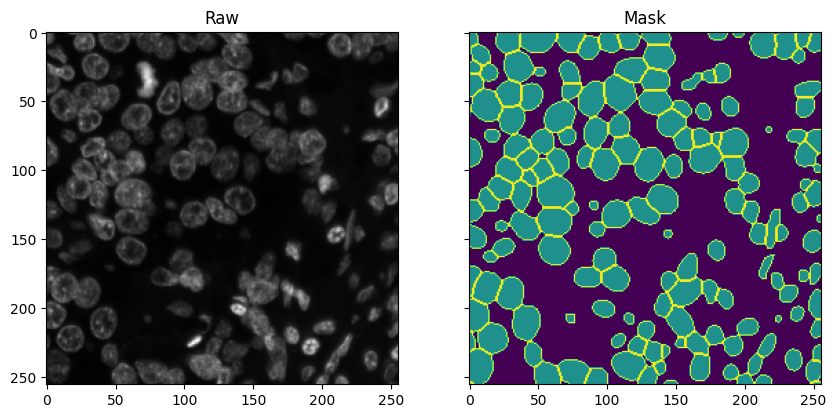

In [23]:
# try each prediction type
prediction_type = 'three_class'


#train_dataset = TissueNetDataset(test_X[:100], test_y[:100], crop_size=64)
train_dataset = TissueNetDataset(
    test_X[:100],
    test_y[:100],
    crop_size=256,
    prediction_type=prediction_type)

raw, mask = train_dataset[random.randrange(len(train_dataset))]
#mask = np.squeeze(mask)

fig, axes = plt.subplots(1,2,figsize=(10, 10),sharex=True,sharey=True,squeeze=False)

axes[0][0].imshow(np.squeeze(raw), cmap='gray')
axes[0][0].title.set_text('Raw')

if mask.shape[0] == 1:
    axes[0][1].imshow(np.squeeze(mask))
    axes[0][1].title.set_text('Mask')
else:
    # affs has two channels (x/y)
    axes[0][1].imshow(mask[0]+mask[1])
    axes[0][1].title.set_text('Mask')

In [24]:
#### Solution ####

def get_hyperparams(prediction_type):

    if prediction_type == "two_class":
        out_channels = 1
        activation = torch.nn.Sigmoid()
        loss_fn = torch.nn.BCELoss()
        dtype = torch.FloatTensor

    elif prediction_type == "three_class":
        out_channels = 3
        activation = torch.nn.Softmax(dim=1)
        loss_fn = torch.nn.CrossEntropyLoss()
        dtype = torch.LongTensor

    elif prediction_type == "sdt":
        out_channels = 1
        activation = torch.nn.Tanh()
        loss_fn = torch.nn.MSELoss()
        dtype = torch.FloatTensor

    elif prediction_type == "affs":
        out_channels = 2
        activation = torch.nn.Sigmoid()
        loss_fn = torch.nn.MSELoss()
        dtype = torch.FloatTensor

    else:
        raise RuntimeError("invalid prediction type")
        
    params = {
        'out_channels': out_channels,
        'activation': activation,
        'loss_function': loss_fn,
        'dtype': dtype
    }
        
    return params

In [25]:
prediction_type = 'three_class'

params = get_hyperparams(prediction_type)

print(params)

{'out_channels': 3, 'activation': Softmax(dim=1), 'loss_function': CrossEntropyLoss(), 'dtype': <class 'torch.LongTensor'>}


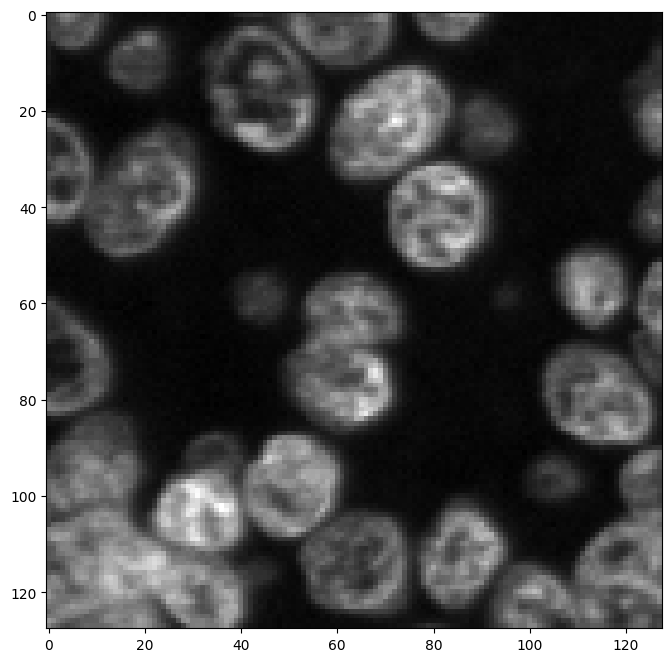

In [29]:
raw, mask = train_dataset[random.randrange(len(train_dataset))]

net_t = raw
fovs = []
d_factors = [[2,2],[2,2],[2,2]]
'''
net = UNet(in_channels=1,
           num_fmaps=6,
           fmap_inc_factors=2,
           downsample_factors=d_factors,
           padding='same'
          )

for level in range(len(d_factors)+1):
    fov_tmp, _ = net.rec_fov(level , (1, 1), 1)
    fovs.append(fov_tmp[0])
'''

torch.manual_seed(42)

d_factors = [[2,2],[2,2],[2,2]]
in_channels=1
num_fmaps=32
fmap_inc_factors=3
padding='same'
final_kernel_size=1
out_channels = params['out_channels']

unet = UNet(
        in_channels=in_channels,
        num_fmaps=num_fmaps,
        fmap_inc_factors=fmap_inc_factors,
        downsample_factors=d_factors,
        padding=padding)

final_conv = torch.nn.Conv2d(
    in_channels=num_fmaps,
    out_channels=out_channels,
    kernel_size=final_kernel_size)

net = torch.nn.Sequential(unet, final_conv)
fig=plt.figure(figsize=(8, 8))
colors = ["yellow", "red", "green", "blue"]

plt.imshow(np.squeeze(raw), cmap='gray')

for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = raw.shape[1]/2 - fov_t/2
    xmax = raw.shape[1]/2 + fov_t/2
    ymin = raw.shape[1]/2 - fov_t/2
    ymax = raw.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()

In [30]:
training_steps = 3000
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

net = net.to(device)
loss_fn = params['loss_function'].to(device)
activation = params['activation']
dtype = params['dtype']

crop_size = 128
prediction_type = 'three_class'

### create datasets
train_dataset = TissueNetDataset(test_X[:100], test_y[:100], crop_size=crop_size, prediction_type=prediction_type)
test_dataset = TissueNetDataset(test_X[100:200], test_y[100:200], crop_size=crop_size, prediction_type=prediction_type)
val_dataset = TissueNetDataset(test_X[200:300], test_y[200:300], crop_size=crop_size,  prediction_type=prediction_type)

batch_size = 4

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)

# set optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# run training loop
train(train_loader, val_loader, net, loss_fn, activation, optimizer, dtype, prediction_type)

  0%|          | 0/3000 [00:00<?, ?it/s]

  3%|▎         | 102/3000 [00:07<09:19,  5.18it/s]

0.780883


  7%|▋         | 204/3000 [00:14<04:03, 11.47it/s]

0.80191267


 10%|█         | 304/3000 [00:20<03:35, 12.49it/s]

0.7798696


 13%|█▎        | 404/3000 [00:26<04:15, 10.17it/s]

0.7757582


 17%|█▋        | 504/3000 [00:32<03:51, 10.79it/s]

0.79427683


 20%|██        | 602/3000 [00:38<03:50, 10.42it/s]

0.75062555


 23%|██▎       | 704/3000 [00:44<03:20, 11.46it/s]

0.87765855


 27%|██▋       | 802/3000 [00:50<04:41,  7.80it/s]

0.77268374


 30%|███       | 902/3000 [00:56<03:20, 10.47it/s]

0.857523


 33%|███▎      | 1003/3000 [01:03<03:52,  8.60it/s]

0.7531811


 37%|███▋      | 1102/3000 [01:09<02:59, 10.56it/s]

0.8364178


 40%|████      | 1202/3000 [01:15<03:53,  7.71it/s]

0.9049893


 43%|████▎     | 1302/3000 [01:21<03:19,  8.51it/s]

0.8394381


 47%|████▋     | 1404/3000 [01:28<02:28, 10.77it/s]

0.8112548


 50%|█████     | 1504/3000 [01:34<02:25, 10.25it/s]

0.98538095


 53%|█████▎    | 1603/3000 [01:40<02:04, 11.19it/s]

0.85694975


 57%|█████▋    | 1704/3000 [01:46<01:51, 11.62it/s]

0.99017334


 60%|██████    | 1803/3000 [01:51<02:06,  9.43it/s]

1.014998


 63%|██████▎   | 1902/3000 [01:58<01:50,  9.90it/s]

0.85542


 67%|██████▋   | 2003/3000 [02:04<01:37, 10.23it/s]

0.8626857


 70%|███████   | 2104/3000 [02:10<01:17, 11.61it/s]

0.7881012


 73%|███████▎  | 2204/3000 [02:16<01:04, 12.29it/s]

0.79906195


 77%|███████▋  | 2304/3000 [02:22<00:56, 12.42it/s]

0.90876395


 80%|████████  | 2402/3000 [02:28<01:09,  8.58it/s]

1.0104294


 83%|████████▎ | 2503/3000 [02:34<00:49, 10.07it/s]

0.7933649


 87%|████████▋ | 2603/3000 [02:39<00:37, 10.66it/s]

0.88736933


 90%|█████████ | 2702/3000 [02:45<00:28, 10.47it/s]

0.76244146


 93%|█████████▎| 2802/3000 [02:51<00:22,  8.92it/s]

0.97309494


 97%|█████████▋| 2904/3000 [02:57<00:08, 11.68it/s]

0.85136247


100%|██████████| 3000/3000 [03:04<00:00, 16.29it/s]

0.91272


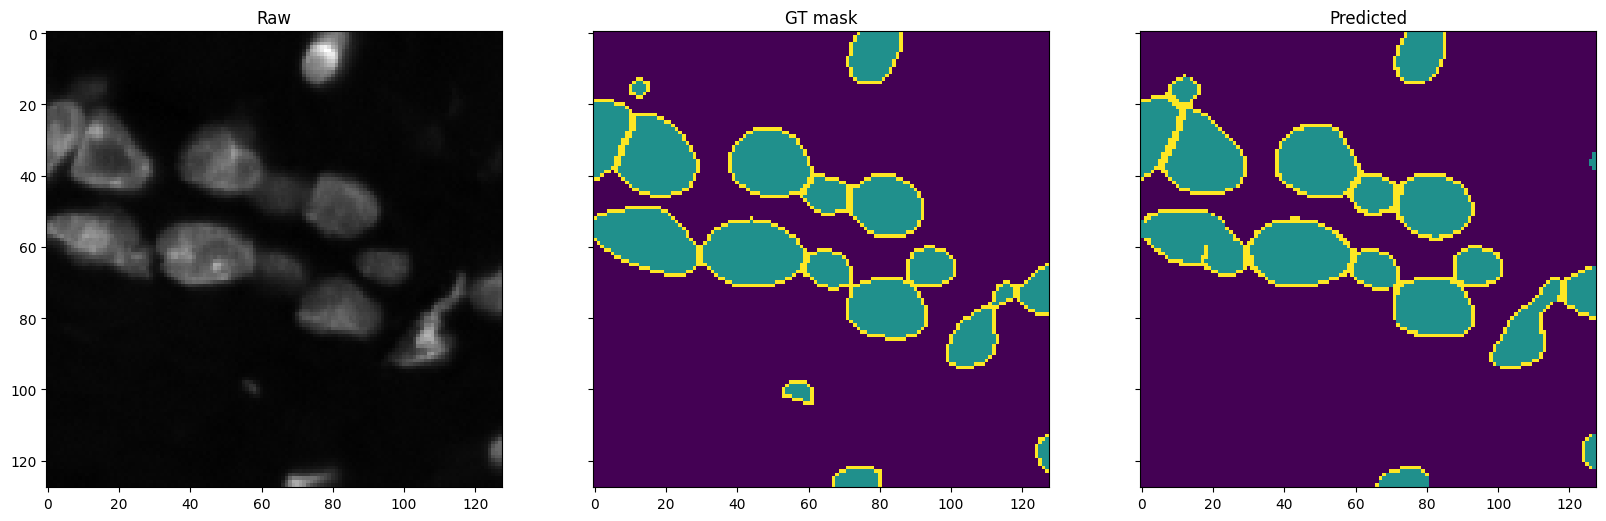

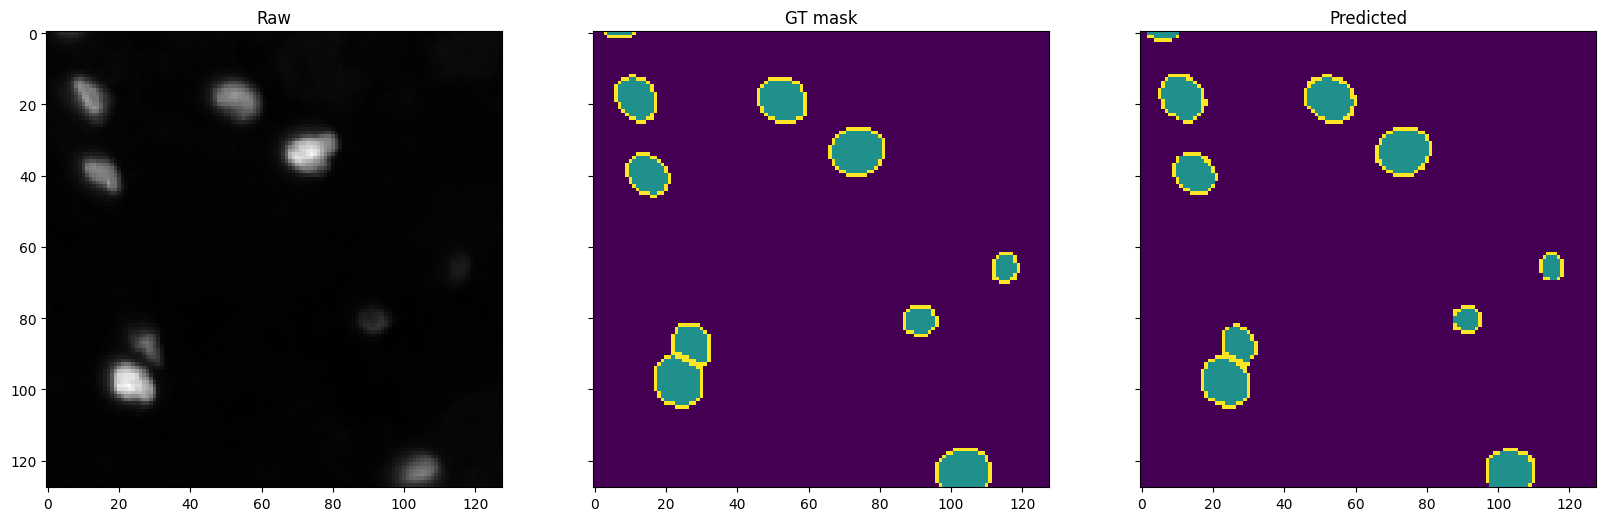

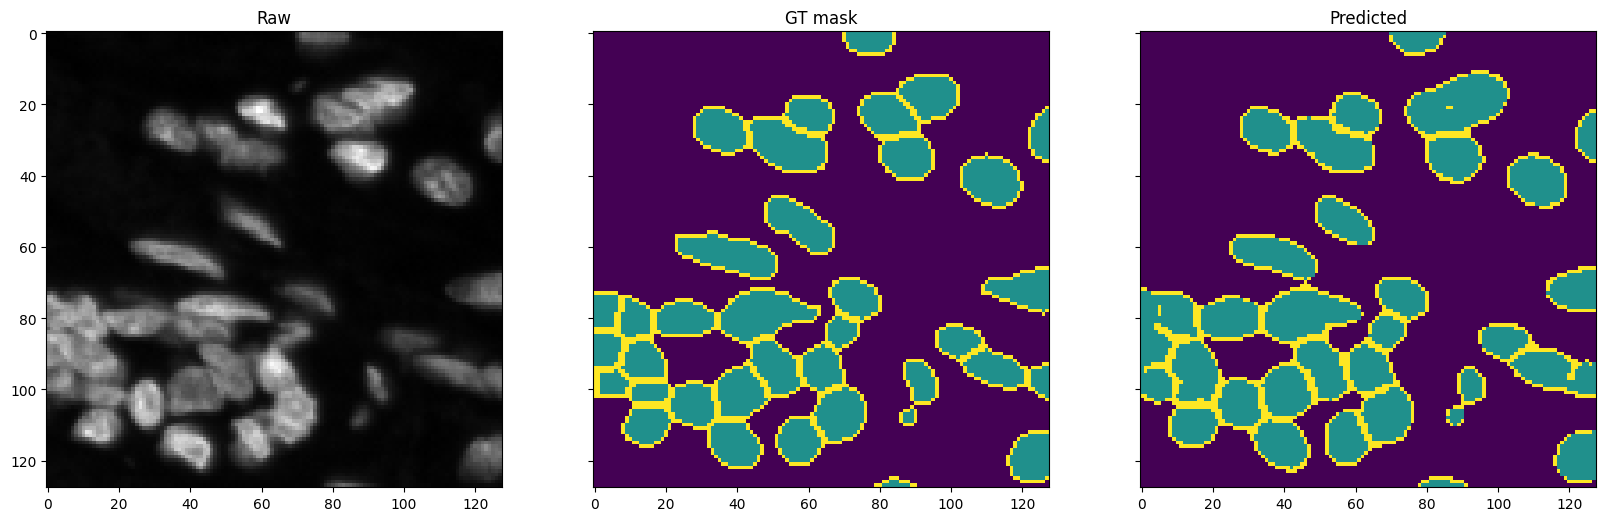

In [31]:
# Visualize predictions

net.eval()

for idx, (image, mask) in enumerate(test_loader):
    image = image.to(device)
    logits = net(image)
    pred = activation(logits)
        
    image = np.squeeze(image.cpu())
    mask = np.squeeze(mask.cpu().numpy())
    
    pred = np.squeeze(pred.cpu().detach().numpy())
        
    fig, axes = plt.subplots(1,3,figsize=(20, 20),sharex=True,sharey=True,squeeze=False)
    
    axes[0][0].imshow(image, cmap='gray')
    axes[0][0].title.set_text('Raw')
    
    if prediction_type == 'three_class':
        # get indices of the maximum values along channel axis
        pred_ = np.argmax(pred, axis=0)
        
    if prediction_type == 'affs':
        axes[0][1].imshow(mask[0] + mask[1])
        axes[0][1].title.set_text('GT mask')
        axes[0][2].imshow(pred[0] + pred[1])
        axes[0][2].title.set_text('Predicted')
        
    else:
        axes[0][1].imshow(mask)
        axes[0][1].title.set_text('GT mask')
        axes[0][2].imshow(pred_)
        axes[0][2].title.set_text('Predicted')
      
    if idx == 2:
        break

In [38]:
pred.shape

(6, 128, 128)

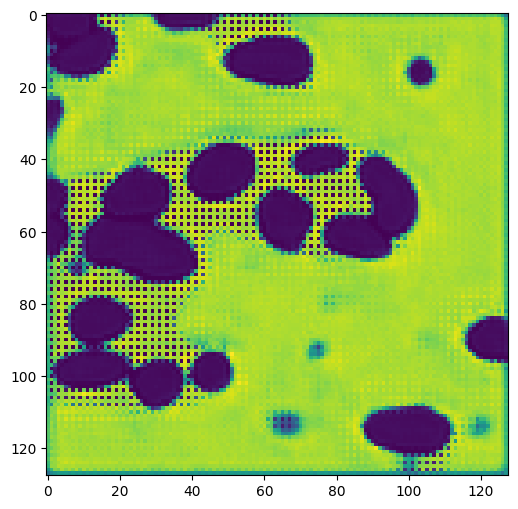

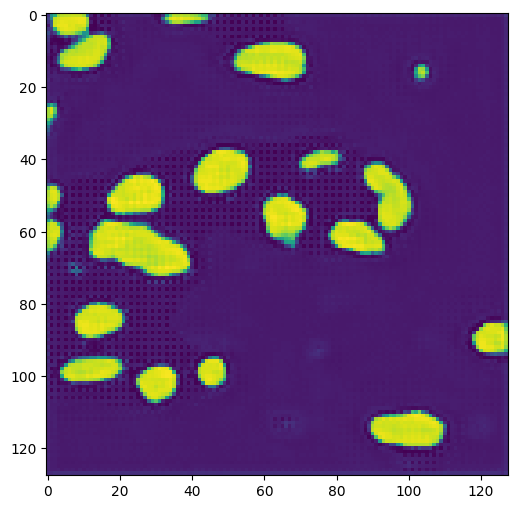

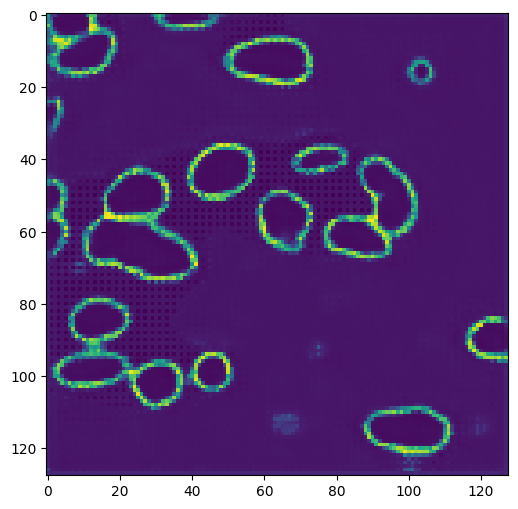

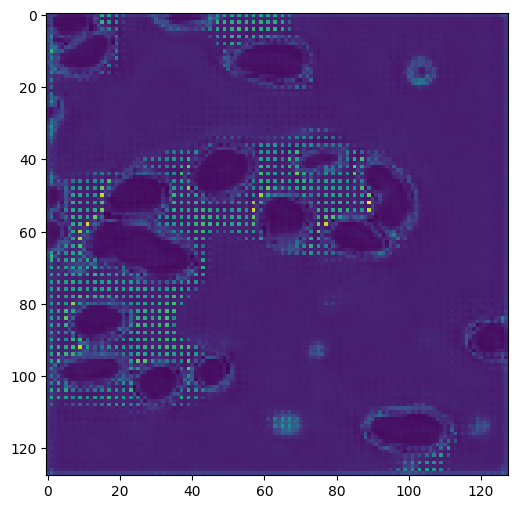

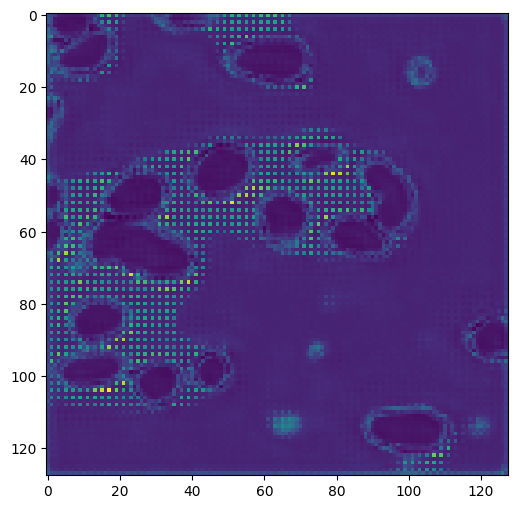

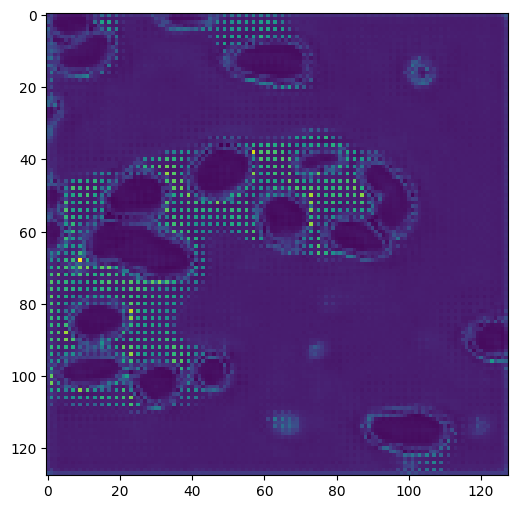

In [41]:
from tnia.plotting.plt_helper import imshow2d

for i in range(pred.shape[0]):
    fig=imshow2d(pred[i])